Параметры:
A = 30, B = 6, f1 = 6 Гц, f2 = 450 Гц
Фильтрация: уровень = 0.2, порог = 149444.489
Фильтрация: уровень = 0.2, порог = 28330.695


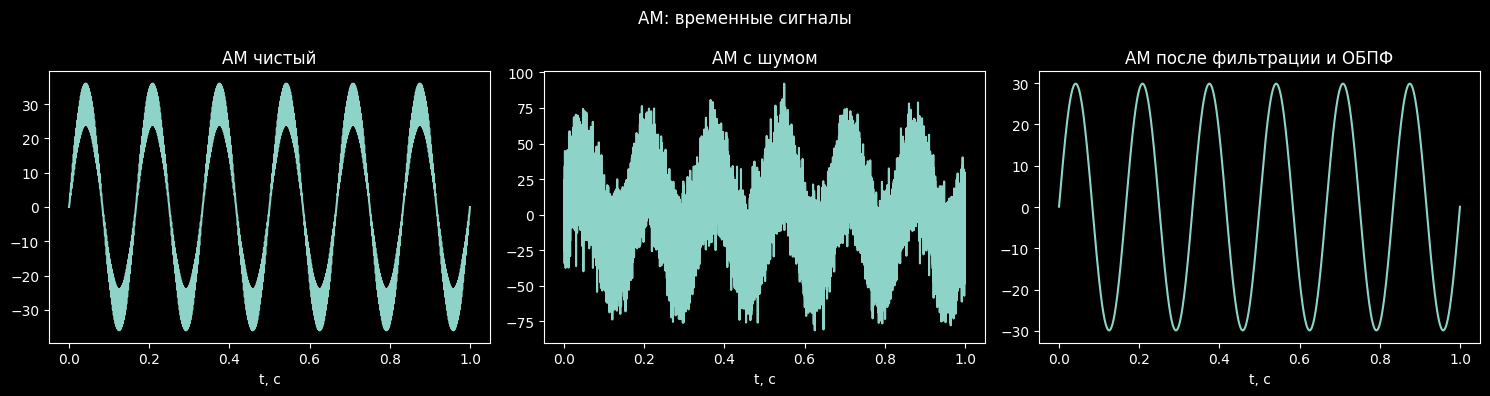

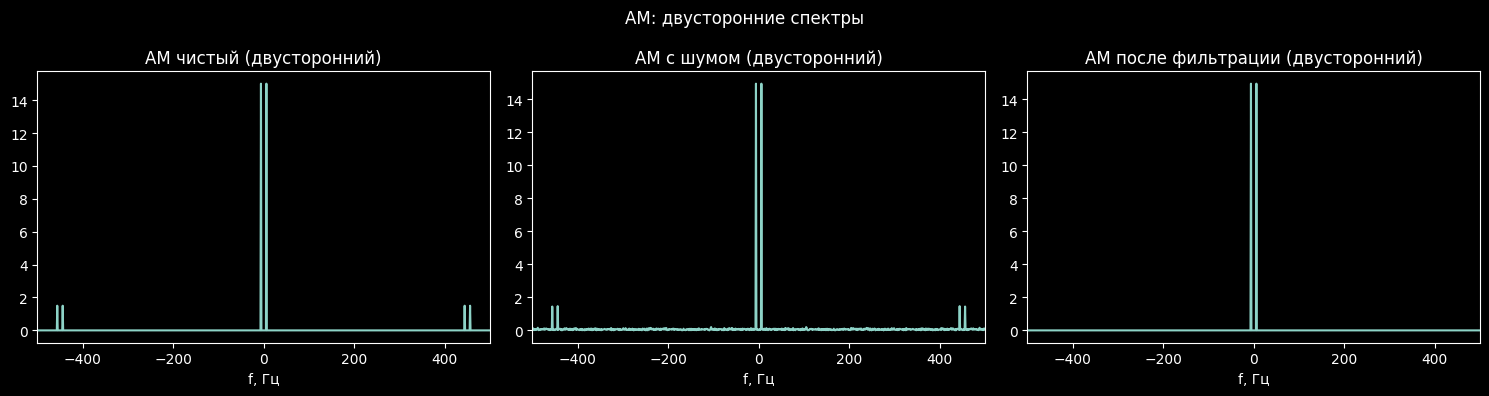

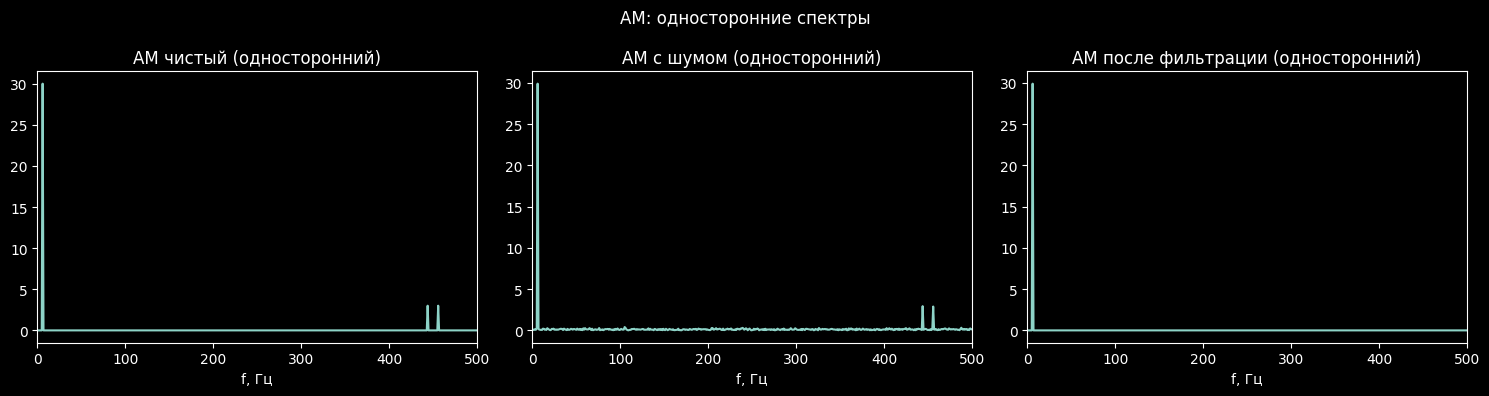

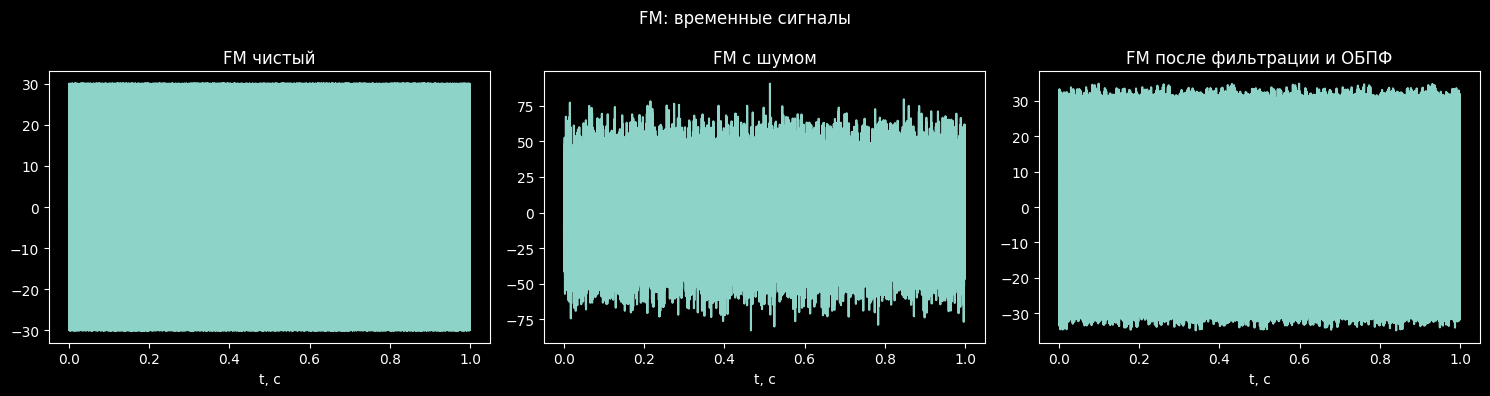

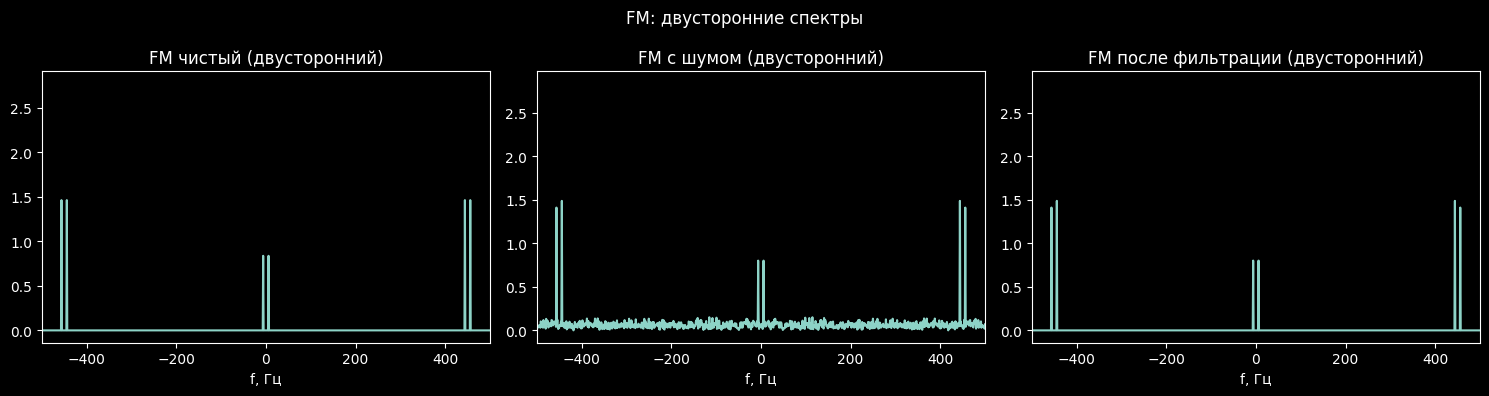

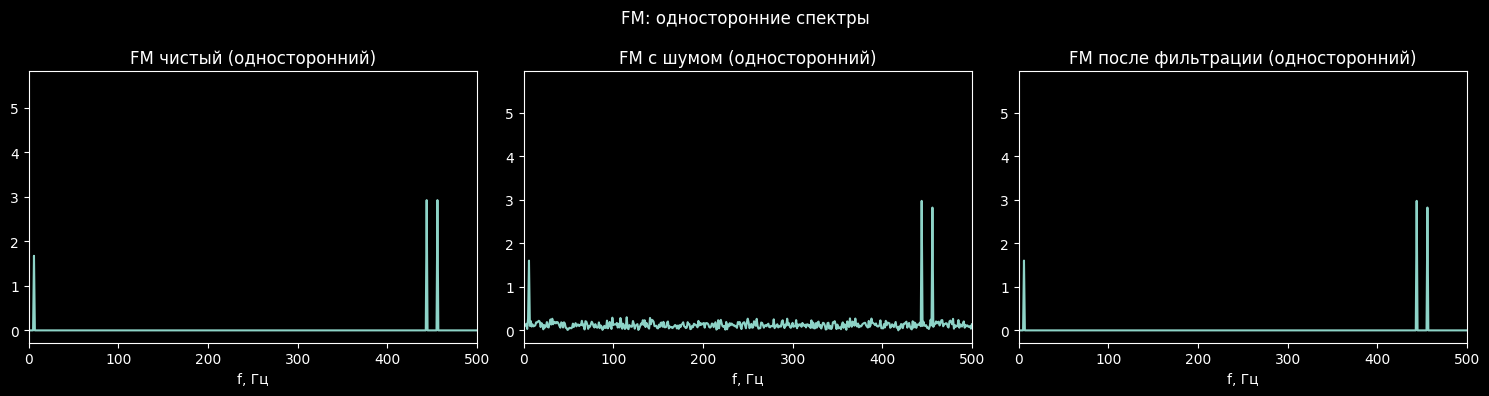


Пояснение:
- Односторонний спектр рассчитан с нормировкой амплитуд (умножение на 2 для положительных частот, кроме постоянной и Nyquist).
- Двухсторонний спектр показывает положительные и отрицательные частоты (сдвинут и нормирован на N).
- Пороговая фильтрация: threshold = max(|X|) * level. Чем больше level, тем выше порог и тем строже отбрасываются слабые гармоники (меньше компонентов остаётся); чем меньше level, тем слабее фильтрация (больше гармоник сохраняется). Сейчас level = 0.2.
- Обратное БПФ применено к результату фильтрации спектра (см. AM после фильтрации и FM после фильтрации).


In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Функция пороговой фильтрации спектра: зануляет гармоники ниже fraction*max
def spectral_filter(X, level=0.2):
    # X - комплексный спектр (двухсторонний, без сдвига)
    threshold = np.max(np.abs(X)) * level
    print(f"Фильтрация: уровень = {level}, порог = {threshold:.3f}")
    return X * (np.abs(X) > threshold)

# Односторонний спектр (корректная нормировка амплитуд для сигналов реальной области)
def one_sided_spectrum(X, Fs):
    N = len(X)
    X_mag = np.abs(X) / N
    if N % 2 == 0:
        # включаем частоту Nyquist
        X_pos = X_mag[:N//2 + 1].copy()
        X_pos[1:-1] *= 2
        f_pos = np.linspace(0, Fs/2, N//2 + 1)
    else:
        X_pos = X_mag[:(N+1)//2].copy()
        X_pos[1:] *= 2
        f_pos = np.linspace(0, Fs/2, (N+1)//2)
    return f_pos, X_pos

# Двухсторонний спектр (сдвинутый для удобства отображения на оси частот)
def two_sided_spectrum(X, Fs):
    N = len(X)
    f = np.fft.fftfreq(N, 1/Fs)
    X_mag = np.abs(X) / N
    f_shift = np.fft.fftshift(f)
    X_shift = np.fft.fftshift(X_mag)
    return f_shift, X_shift

# Параметры задания
N = 3
k = 1
Fs = 50000
T = 1

if N % 2 == 0:  # четный вариант
    A = 15 * N
    B = 1 * N
    f1 = 3 * k * N
    f2 = 100 * N
else:  # нечетный вариант
    A = 10 * N
    B = 2 * N
    f1 = 2 * k * N
    f2 = 150 * N

print(f"Параметры:\nA = {A}, B = {B}, f1 = {f1} Гц, f2 = {f2} Гц")

# Сетка времени
t = np.linspace(0, T, int(Fs*T), endpoint=False)

omega_carrier = 2 * np.pi * f1
omega_info = 2 * np.pi * f2

# Порог для фильтрации: изменяйте level, чтобы сильнее/слабее обрезать мелкие гармоники
level = 0.2

# --- АМ ---
m = B / A
am_clean = A * (1 + m * np.sin(omega_info * t)) * np.sin(omega_carrier * t)
noise_am = np.random.normal(0, A*0.5, size=len(t))
am_noisy = am_clean + noise_am

# FFT для каждого этапа
fft_am_clean = np.fft.fft(am_clean)
fft_am_noisy = np.fft.fft(am_noisy)
fft_am_filtered = spectral_filter(fft_am_noisy.copy(), level=level)
am_rec = np.fft.ifft(fft_am_filtered).real

# --- ЧМ (FM) ---
kf = 50
fm_clean = A * np.sin(2*np.pi*f1*t + kf * np.sin(2*np.pi*f2*t))
noise_fm = np.random.normal(0, A*0.5, size=len(t))
fm_noisy = fm_clean + noise_fm

fft_fm_clean = np.fft.fft(fm_clean)
fft_fm_noisy = np.fft.fft(fm_noisy)
fft_fm_filtered = spectral_filter(fft_fm_noisy.copy(), level=level)
fm_rec = np.fft.ifft(fft_fm_filtered).real

# Построение графиков: для каждой модуляции показываем временные сигналы (чистый/с шумом/фильтрованный),
# двухсторонние и односторонние спектры для каждой стадии.

# Вспомогательная функция для компактного рисования трёх временных сигналов
def plot_time_signals(t, signals, titles, suptitle=None, figsize=(12,6)):
    plt.figure(figsize=figsize)
    for i, (s, title) in enumerate(zip(signals, titles), 1):
        plt.subplot(1, len(signals), i)
        plt.plot(t, s)
        plt.title(title)
        plt.xlabel('t, с')
    if suptitle:
        plt.suptitle(suptitle)
    plt.tight_layout()

# Вспомогательная функция для рисования двухсторонних спектров
def plot_two_sided(X_list, labels, Fs, xlim=None, suptitle=None, figsize=(12,6)):
    plt.figure(figsize=figsize)
    for i, (X, lbl) in enumerate(zip(X_list, labels), 1):
        f_shift, X_shift = two_sided_spectrum(X, Fs)
        plt.subplot(1, len(X_list), i)
        plt.plot(f_shift, X_shift)
        plt.title(lbl)
        plt.xlabel('f, Гц')
        if xlim:
            plt.xlim(-xlim, xlim)
    if suptitle:
        plt.suptitle(suptitle)
    plt.tight_layout()

# Вспомогательная функция для рисования односторонних спектров
def plot_one_sided(X_list, labels, Fs, xlim=None, suptitle=None, figsize=(12,6)):
    plt.figure(figsize=figsize)
    for i, (X, lbl) in enumerate(zip(X_list, labels), 1):
        f_pos, X_pos = one_sided_spectrum(X, Fs)
        plt.subplot(1, len(X_list), i)
        plt.plot(f_pos, X_pos)
        plt.title(lbl)
        plt.xlabel('f, Гц')
        if xlim:
            plt.xlim(0, xlim)
    if suptitle:
        plt.suptitle(suptitle)
    plt.tight_layout()

# Рисуем для AM
plot_time_signals(t, [am_clean, am_noisy, am_rec], ['AM чистый', 'AM с шумом', 'AM после фильтрации и ОБПФ'], suptitle='AM: временные сигналы', figsize=(15,4))
plot_two_sided([fft_am_clean, fft_am_noisy, fft_am_filtered], ['AM чистый (двусторонний)', 'AM с шумом (двусторонний)', 'AM после фильтрации (двусторонний)'], Fs, xlim=500, suptitle='AM: двусторонние спектры', figsize=(15,4))
plot_one_sided([fft_am_clean, fft_am_noisy, fft_am_filtered], ['AM чистый (односторонний)', 'AM с шумом (односторонний)', 'AM после фильтрации (односторонний)'], Fs, xlim=500, suptitle='AM: односторонние спектры', figsize=(15,4))

# Рисуем для FM
plot_time_signals(t, [fm_clean, fm_noisy, fm_rec], ['FM чистый', 'FM с шумом', 'FM после фильтрации и ОБПФ'], suptitle='FM: временные сигналы', figsize=(15,4))
plot_two_sided([fft_fm_clean, fft_fm_noisy, fft_fm_filtered], ['FM чистый (двусторонний)', 'FM с шумом (двусторонний)', 'FM после фильтрации (двусторонний)'], Fs, xlim=500, suptitle='FM: двусторонние спектры', figsize=(15,4))
plot_one_sided([fft_fm_clean, fft_fm_noisy, fft_fm_filtered], ['FM чистый (односторонний)', 'FM с шумом (односторонний)', 'FM после фильтрации (односторонний)'], Fs, xlim=500, suptitle='FM: односторонние спектры', figsize=(15,4))

plt.show()

# Краткое пояснение для отчёта
print('\nПояснение:')
print('- Односторонний спектр рассчитан с нормировкой амплитуд (умножение на 2 для положительных частот, кроме постоянной и Nyquist).')
print('- Двухсторонний спектр показывает положительные и отрицательные частоты (сдвинут и нормирован на N).')
print(f'- Пороговая фильтрация: threshold = max(|X|) * level. Чем больше level, тем выше порог и тем строже отбрасываются слабые гармоники (меньше компонентов остаётся); чем меньше level, тем слабее фильтрация (больше гармоник сохраняется). Сейчас level = {level}.')
print('- Обратное БПФ применено к результату фильтрации спектра (см. AM после фильтрации и FM после фильтрации).')
